In [1]:
import kmlparser as parser
import monthly
from geopandas import read_file
import pandas as pd

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl

c:\Users\Francisco Ruiz\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Prepare Data

First, let's parse the *kml* file which has the URLs to the statistics HTML file. For that is neccessary to pass a `pd.Series` type object with the respective station points into `seekData()` function.

In [ ]:
kmlFile = r'EstacionesClimatologicas\doc.kml'
pointsFile = r'EstacionesClimatologicas\ROI.gpkg'

vectorPoints = read_file(pointsFile, layer='stats')
stats = vectorPoints.Name

Now, we're going to scrape the _**xml**_ content from _**kml**_ file to get the URL that will take us to statistics HTML file for the desired period passed. Once the link has been recovered, a new folder created by default into the current working directory named **RawData** will contain one __txt__ file for each station. There will exists the same data than we could find in the **National Meteorological Service**  official web page.

If you want to change the root and folder name container, just pass `directory` argument into the parser with the desired path.

In [ ]:
parser.seekData(kmlFile, vectorPoints['Name'], 'MENSUALES', directory='RD_ProcessChunk')

## Create DB

Create a **shelve** file with the raw data sorted by topic; that is, the kind of meteorological variable (e.g. Maximum Temperature, Averaged Precipitation)

In [ ]:
monthly.createDB('RD_ProcessChunk')

# Determinate year range

Load pre-structured data by topic of interest. `loadData()` function provides all the valid variable values for its `variable` argument.

In [8]:
for var in monthly.__topics__:
    df = monthly.loadData(var)
    print("%s: %i records" % (var, df.shape[0]))

pmax24: 9736 records
p: 9736 records
evo: 6611 records
tmax_x: 9400 records
tmax_mean: 9400 records
tmin_x: 9398 records
tmin_mean: 9398 records
t: 9393 records


In [ ]:
p = monthly.loadData('p')


y_label = p.stat.unique()
x_label = range(p.year.min(), p.year.max() + 1)
data = pd.DataFrame({'year': p.year, 'stat':p.stat})

mx, mn = y_label.max(), y_label.min()
class1 = data.query('@mn <= stat < 12000')
class2 = data.query('%i < stat < 16000' % class1.stat.max())
class3 = data.query('%i < stat < 18000' % class2.stat.max())
class4 = data.query('%i < stat < 24000' % class3.stat.max())
class5 = data.query('%i < stat <= @mx' % class4.stat.max())

plots = class1, class2, class3, class4, class5
sb.set_style('darkgrid')
fig, axs = plt.subplots(nrows=5, tight_layout=True)
fig.set_size_inches(15, 50, True)
for i,plot in enumerate(plots):
    stats = plot.stat.unique()
    for stat in stats:
        filtered = plot[plot.stat == stat]
        if not filtered.empty:
            axs[i].scatter(filtered.year, filtered.stat)
    axs[i].set_ylim(ymin=stats.min(), ymax=stats.max())
    axs[i].set_xlim(xmin=1980, xmax=2023)
    axs[i].set_xlabel('Año')
    axs[i].set_ylabel('Estación')
plt.show()

As we can see in the graphs the mayor amount of stations with at least one available record falls within **1980** to **2020**. Therefore, let's now filter the stations considering a tolerance for missing records (MR) per station.

# Filtering with a tolerance of **5% MR**

In [2]:
p = monthly.loadData('p')
t = monthly.loadData('t')
tmin = monthly.loadData('tmin_mean')
tmax = monthly.loadData('tmax_mean')

In [3]:
p.year = p.year.astype('int')
t.year = t.year.astype('int')
tmin.year = tmin.year.astype('int')
tmax.year = tmax.year.astype('int')

p.months_amount = p.months_amount.astype('int')
t.months_amount = t.months_amount.astype('int')
tmin.months_amount = tmin.months_amount.astype('int')
tmax.months_amount = tmax.months_amount.astype('int')

First of all, select records between 1980 and 2020 for each variable.

In [4]:
p5 = p.query('1980 <= year <= 2020')
t5 = t.query('1980 <= year <= 2020')
tmin5 = tmin.query('1980 <= year <= 2020')
tmax5 = tmax.query('1980 <= year <= 2020')

Select stations in common for all the varibles.

In [5]:
common_stats = set(p5.stat.unique()).intersection(t5.stat.unique()).intersection(tmin5.stat.unique()).intersection(tmax5.stat.unique())

cols2drop = ['acum', 'mean']
p_filtered = p5[p5.stat.isin(common_stats)].drop(cols2drop, axis=1)
t_filtered = t5[t5.stat.isin(common_stats)].drop(cols2drop, axis=1)
tmin_filtered = tmin5[tmin5.stat.isin(common_stats)].drop(cols2drop, axis=1)
tmax_filtered = tmax5[tmax5.stat.isin(common_stats)].drop(cols2drop, axis=1)

print(f"{common_stats.__len__()} stations in common")

198 stations in common


Get the total number of mounths with data. For that, let's create a new DataFrame with the number of months with data for each variable considered. And then, get the sum among all this amounts to get a total months amount

In [24]:
data = p_filtered[['stat', 'year', 'months_amount']].join(t_filtered[['months_amount']].add_suffix('_t')).join(tmin_filtered[['months_amount']].add_suffix('_tmin')).join(tmax_filtered[['months_amount']].add_suffix('_tmax'))
amounts = data.columns[2:]
new = data.drop('year', axis=1).groupby('stat').sum()
new['totals'] = new.apply(lambda record: record.sum(), axis=1)
full = new[['totals']]
full['totals'].mode()

0       37.0
1       70.0
2      132.0
3      139.0
4      192.0
5      402.0
6      756.0
7     1243.0
8     1277.0
9     1298.0
10    1359.0
11    1440.0
12    1512.0
13    1682.0
14    1714.0
15    1745.0
Name: totals, dtype: float64

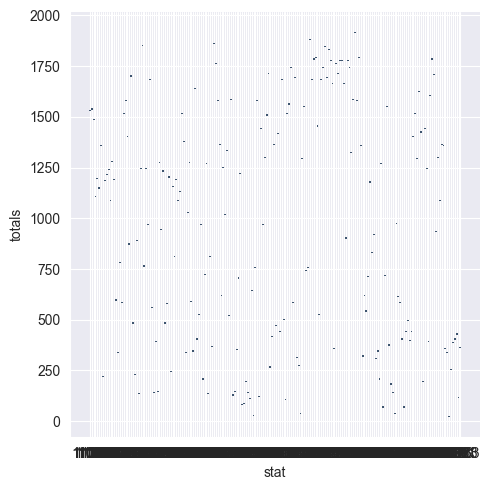

In [19]:
sb.set_style('darkgrid')
# fig, axs = plt.subplots(nrows=1, tight_layout=True)
# fig.set_size_inches(15, 50, True)
sb.displot(full, x=full.index, y='totals', binwidth=6)

# filtered_groups = months_per_stat.filter(lambda x: x['months_amount'].sum() > 468).groupby('stat').sum()